<a href="https://colab.research.google.com/github/Cervisiomatisch/Bachelorthesis/blob/main/casestudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fallstudie - Anomalie-Erkennung in PostgreSQL-Logs

Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import re
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import hstack

In [ ]:
print(f"Numpy Version:        {np.__version__}")
print(f"Pandas Version:       {pd.__version__}")
print(f"Scikit-Learn Version: {sklearn.__version__}")
print(f"Matplotlib Version:   {mpl.__version__}")
print(f"Re Version:           {re.__version__}")
print(f"Scipy Version:        {scipy.__version__}")

Numpy Version:        2.0.2
Pandas Version:       2.2.2
Scikit-Learn Version: 1.6.1
Matplotlib Version:   3.10.0
Re Version:           2.2.1
Scipy Version:        1.16.1


## 1. PostgreSQL-Logs einlesen

In [ ]:
log_lines = []
with open("/content/log1.txt", 'r') as file:
  for line in file:
    log_lines.append(line)

Damit wurde eine von PostgreSQL erstellte Log-Datei zeilenweise eingelesen und in log_lines abgespeichert. Dabei ist jeder Log-Eintrag (jede Zeile) eine Eintrag in der Liste. Um den Inhalt zu präsentieren, können die ersten fünf Elemente ausgegeben werden.

In [ ]:
log_lines[:5]

['2025-07-18 10:46:30.864 CEST [421791] user=,db=,app=,host=,session=687a09e6.66f9f,xid=0,state=00000LOG:  PostgreSQL 15.13 (Debian 15.13-1.pgdg120+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit startet\n',
 '2025-07-18 10:46:30.864 CEST [421791] user=,db=,app=,host=,session=687a09e6.66f9f,xid=0,state=00000LOG:  erwarte Verbindungen auf IPv4-Adresse »0.0.0.0«, Port 5432\n',
 '2025-07-18 10:46:30.864 CEST [421791] user=,db=,app=,host=,session=687a09e6.66f9f,xid=0,state=00000LOG:  erwarte Verbindungen auf IPv6-Adresse »::«, Port 5432\n',
 '2025-07-18 10:46:30.866 CEST [421791] user=,db=,app=,host=,session=687a09e6.66f9f,xid=0,state=00000LOG:  erwarte Verbindungen auf Unix-Socket »/var/run/postgresql/.s.PGSQL.5432«\n',
 '2025-07-18 10:46:30.870 CEST [421795] user=,db=,app=,host=,session=687a09e6.66fa3,xid=0,state=00000LOG:  Datenbanksystem wurde am 2025-07-18 10:46:30 CEST heruntergefahren\n']

Die gesamte Log-Datei beinhaltet diese Anzahl an Log-Einträgen:

In [ ]:
len(log_lines)

301

Diese 301 Logeinträge müssen nun Analysiert und in ein strukturiertes Format überführt werden.

## 2. Analyse und Vorverarbeitung

In [ ]:
def show_logs(log_lines):
  for i, log in enumerate(log_lines):
    print(f"{i+1}. {log}")

In [ ]:
# show_logs(log_lines)

Eine kurze Analyse hat gezeigt, dass die Anweisungen und die Ausführungszeiten nicht im selben Eintrag stehen.

In [ ]:
print(f'Zeile 44: {log_lines[44]} \n Zeile 45: {log_lines[45]}')

Zeile 44: 2025-07-18 10:48:59.631 CEST [421817] user=postgres,db=postgres,app=psql,host=testpgdb,session=687a0a0f.66fb9,xid=0,state=00000LOG:  Anweisung: CREATE TEMP TABLE temp_test (id SERIAL PRIMARY KEY, value TEXT);
 
 Zeile 45: 2025-07-18 10:48:59.644 CEST [421817] user=postgres,db=postgres,app=psql,host=testpgdb,session=687a0a0f.66fb9,xid=0,state=00000LOG:  Dauer: 12.903 ms



Dies gilt zu beheben. Weiter sind die Attribute von einander zu trennen und geeignet abzuspeichern, sodass über die Angabe eines Indexes auf den exakten Wert zugegriffen werden kann.

Da die Logs in einem Template angelegt werden, können diese mit RegEx extrahiert werden. Dazu werden pattern angelegt, die für das RegEx genutzt werden.

In [ ]:
# @title RegEx-Patterm

STD_PATTERN = re.compile(
    r"(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3}) "
    r"(?P<timezone>[A-Z]+) "
    r"\[(?P<pid>\d+)\] "
    r"user=(?P<user>[^,]+),"
    r"db=(?P<db>[^,]+),"
    r"app=(?P<app>[^,]+),"
    r"host=(?P<host>[^,]+),"
    r"session=(?P<session>[^,]+),"
    r"xid=(?P<xid>\d+),"
    r"state=(?P<state>\w+)"
    r"(?P<level>LOG):\s+Anweisung: (?P<statement>.+)"
)

DURATION_PATTERN = re.compile(
    r"\[(?P<pid>\d+)\].*?LOG:  Dauer: (?P<duration>[\d\.]+) ms"
)

ERROR_PATTERN = re.compile(
    r"\[(?P<pid>\d+)\].*?state=(?P<state>\w+)?FEHLER:  (?P<error>.+)"
)

DETAIL_PATTERN = re.compile(
    r"DETAIL:  (?P<detail>.+)"
)

FALLBACK_STATEMENT_PATTERN = re.compile(
    r"ANWEISUNG:  (?P<statement>.+)"
)

SKIPPABLE_PATTERN = re.compile(
    r"(HINWEIS|ZUSAMMENHANG):"
)

In [ ]:
def parse_logs(log_lines):
    result = []
    pending_entry = None

    for line in log_lines:
        if SKIPPABLE_PATTERN.search(line):
            continue

        std_match = STD_PATTERN.search(line)
        if std_match:
            pending_entry = std_match.groupdict()
            pending_entry["duration"] = None
            pending_entry["error"] = None
            pending_entry["detail"] = None
            continue

        if pending_entry:
            duration_match = DURATION_PATTERN.search(line)
            if duration_match and duration_match.group("pid") == pending_entry["pid"]:
                pending_entry["duration"] = duration_match.group("duration")
                result.append(pending_entry)
                pending_entry = None
                continue

            error_match = ERROR_PATTERN.search(line)
            if error_match and error_match.group("pid") == pending_entry["pid"]:
                pending_entry["error"] = error_match.group("error")
                if error_match.group("state"):
                    pending_entry["state"] = error_match.group("state")
                pending_entry["level"] = "FEHLER"
                continue

            detail_match = DETAIL_PATTERN.search(line)
            if detail_match:
                pending_entry["detail"] = detail_match.group("detail")
                continue

            fallback_stmt_match = FALLBACK_STATEMENT_PATTERN.search(line)
            if fallback_stmt_match:
                pending_entry["statement"] = fallback_stmt_match.group("statement")
                result.append(pending_entry)
                pending_entry = None
                continue

    if pending_entry:
        result.append(pending_entry)

    return result

In [ ]:
parsed_logs = parse_logs(log_lines)

Nun kann die Liste, die die extrahierten Informationen aus den jeweiligen Log-Einträgen enthält, in ein Dataframe von pandas umgewandelt werden. Dies hilft zur besseren Weiterverarbeitung.

In [ ]:
df = pd.DataFrame(parsed_logs)

Nach der Umwandlung in das strukturierte Format sieht der Datensatz wie folgt aus:

In [ ]:
df.head()

,timestamp,timezone,pid,user,db,app,host,session,xid,state,level,statement,duration,error,detail
0,2025-07-18 10:47:31.870,CEST,421817,postgres,postgres,psql,testpgdb,687a0a0f.66fb9,0,00000,LOG,SELECT NOW();,1.662,None,None
1,2025-07-18 10:47:47.931,CEST,421817,postgres,postgres,psql,testpgdb,687a0a0f.66fb9,0,00000,LOG,SELECT COUNT(*) FROM pg_tables;,4.895,None,None
2,2025-07-18 10:47:56.198,CEST,421817,postgres,postgres,psql,testpgdb,687a0a0f.66fb9,0,00000,LOG,SELECT tablename FROM pg_tables WHERE schemana...,1.861,None,None
3,2025-07-18 10:48:04.118,CEST,421817,postgres,postgres,psql,testpgdb,687a0a0f.66fb9,0,00000,LOG,SELECT * FROM pg_roles LIMIT 5;,1.245,None,None
4,2025-07-18 10:48:33.266,CEST,421817,postgres,postgres,psql,testpgdb,687a0a0f.66fb9,0,00000,LOG,SELECT current_database();,0.602,None,None


In [ ]:
df["duration"] = pd.to_numeric(df["duration"], errors="coerce")
df["duration"].fillna(0, inplace=True)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df_plot = df.dropna(subset=["duration"])

/tmp/ipython-input-4172404040.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["duration"].fillna(0, inplace=True)


## Analyse

Die Logs können nun auf ihren Inhalt untersucht werden. Da hierdrauf nicht der Fokus liegt, wird diese recht kurz gehalten.

In [ ]:
df.value_counts('level')

,count
level,
LOG,125
FEHLER,1


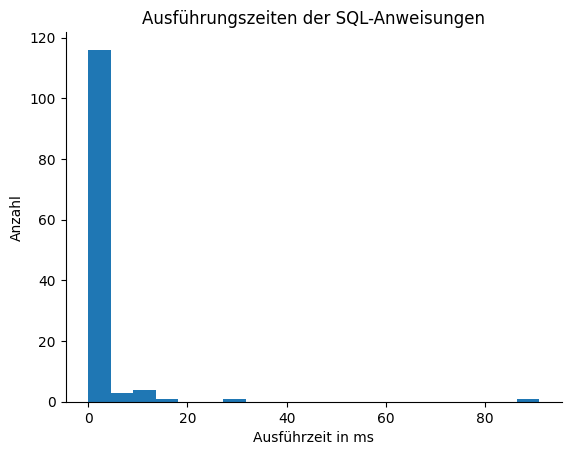

In [ ]:
# @title Ausführungszeiten der SQL-Anweisungen

from matplotlib import pyplot as plt
df['duration'].plot(kind='hist', bins=20, title='Ausführungszeiten der SQL-Anweisungen')
plt.xlabel("Ausführzeit in ms")
plt.ylabel("Anzahl")
plt.gca().spines[['top', 'right',]].set_visible(False)

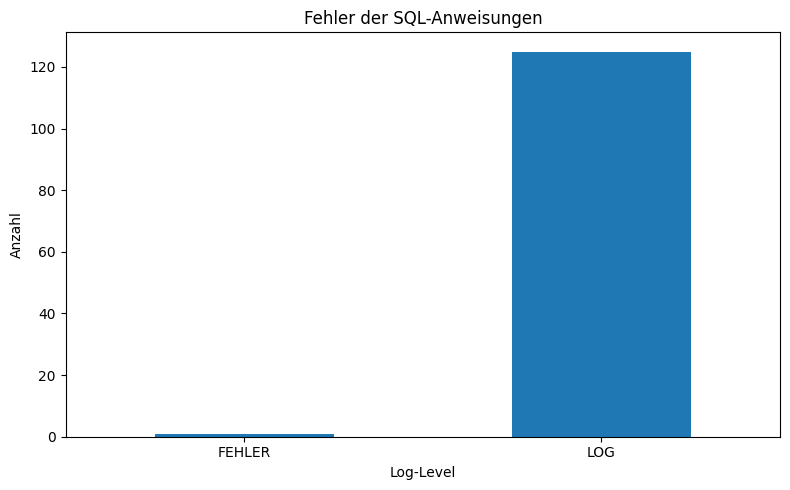

In [ ]:
# @title Fehler der SQL-Anweisungen
level_counts = df['level'].value_counts()

relevant_levels = level_counts[['FEHLER', 'LOG']] if 'FEHLER' in level_counts.index and 'LOG' in level_counts.index else level_counts

plt.figure(figsize=(8, 5))
relevant_levels.plot(kind='bar')
plt.title('Fehler der SQL-Anweisungen')
plt.xlabel('Log-Level')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

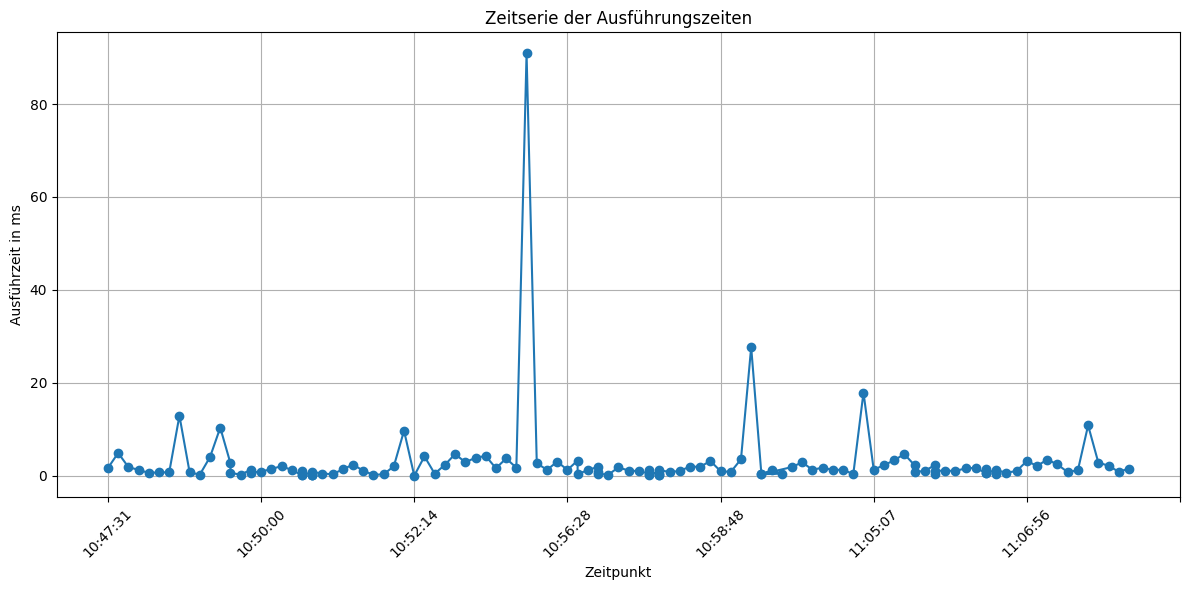

In [ ]:
# @title Zeitserie

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'].dt.strftime('%H:%M:%S'), df["duration"], marker='o')
plt.title("Zeitserie der Ausführungszeiten")
plt.xlabel("Zeitpunkt")
plt.ylabel("Ausführzeit in ms")
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.tight_layout()

plt.show()

Die Analyse hat gezeigt, dass bereits Anzeichen für Anomalien in der Ausführungszeit und der Ausführungsfehler vorhanden sind. Auf diese beiden Attribute wird eine Anomalie-Erkennung durchgeführt.

Um den Datensatz entsprechend vorzubereiten, muss der Fehler in einen numerischen Wert umgewandelt werden. Dazu werden zwei Methoden genutzt. Ein label-encoding und einen tfidfVectorizer.

In [ ]:
df_le = df.copy()
df_le["has_error"] = (df["level"] == "FEHLER").astype(int)
features_le = df_le[["duration", "has_error"]]

In [ ]:
tfidf = TfidfVectorizer()
df_tfidf = df.copy()

level_tfidf = tfidf.fit_transform(df_tfidf["level"])
# X_num = df_tfidf[["duration"]].astype("float64").values
features_tfidf = hstack([level_tfidf, df_tfidf[["duration"]]])

## Modelltraining

Es soll während des Modelltrainings ein Isolation Forest verwendet werden. Dazu wird der Parameter contamination einmal auf 'auto' und einmal auf '0.06' gesetzt und miteinander verglichen.

In [ ]:
model_auto_le = IsolationForest(contamination="auto", random_state=42, bootstrap=True)
model_auto_tfidf = IsolationForest(contamination="auto", random_state=42, bootstrap=True)

model_06_le = IsolationForest(contamination=0.06, random_state=42, bootstrap=True)
model_06_tfidf = IsolationForest(contamination=0.06, random_state=42, bootstrap=True)

In [ ]:
df_le['anomaly_auto'] = model_auto_le.fit_predict(features_le)
df_le['anomaly_06'] = model_06_le.fit_predict(features_le)

df_tfidf['anomaly_auto'] = model_auto_tfidf.fit_predict(features_tfidf)
df_tfidf['anomaly_06'] = model_06_tfidf.fit_predict(features_tfidf)

## Modellevaluierung

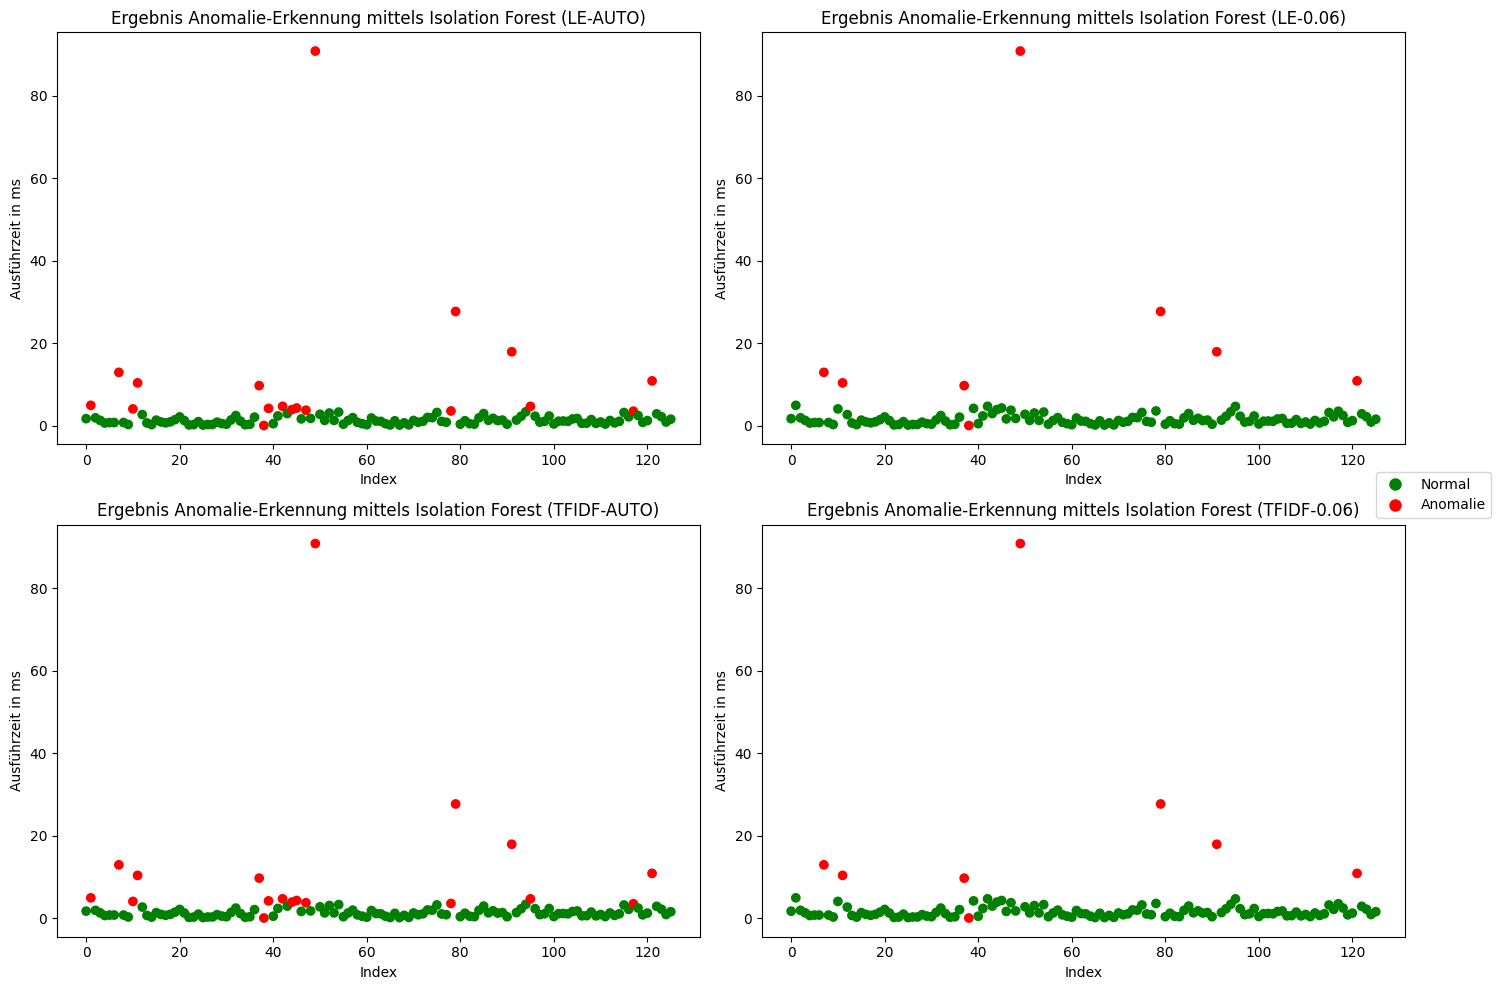

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

models = {
    "LE-AUTO": df_le,
    "LE-0.06": df_le,
    "TFIDF-AUTO": df_tfidf,
    "TFIDF-0.06": df_tfidf,
}

anomaly_cols = {
    "LE-AUTO": 'anomaly_auto',
    "LE-0.06": 'anomaly_06',
    "TFIDF-AUTO": 'anomaly_auto',
    "TFIDF-0.06": 'anomaly_06',
}

titles = {
    "LE-AUTO": "Ergebnis Anomalie-Erkennung mittels Isolation Forest (LE-AUTO)",
    "LE-0.06": "Ergebnis Anomalie-Erkennung mittels Isolation Forest (LE-0.06)",
    "TFIDF-AUTO": "Ergebnis Anomalie-Erkennung mittels Isolation Forest (TFIDF-AUTO)",
    "TFIDF-0.06": "Ergebnis Anomalie-Erkennung mittels Isolation Forest (TFIDF-0.06)",
}

colors = {-1: 'red', 1: 'green'}
labels = {-1: 'Anomalie', 1: 'Normal'}

for i, (title_key, df_data) in enumerate(models.items()):
    anomaly_col = anomaly_cols[title_key]
    title = titles[title_key]

    scatter = axes[i].scatter(df_data.index, df_data["duration"], c=df_data[anomaly_col].map(colors))
    axes[i].set_title(title)
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel("Ausführzeit in ms")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Normal', markersize=10, markerfacecolor='green'),
    Line2D([0], [0], marker='o', color='w', label='Anomalie', markersize=10, markerfacecolor='red')
]

fig.legend(handles=legend_elements, loc='center right')


plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

Darstellung der jeweiligen Logs, die als Anomalie erkannt wurden.

In [ ]:
scenarios = {
    "LE-AUTO": (df_le, 'anomaly_auto'),
    "LE-0.06": (df_le, 'anomaly_06'),
    "TFIDF-AUTO": (df_tfidf, 'anomaly_auto'),
    "TFIDF-0.06": (df_tfidf, 'anomaly_06'),
}

for name, (dataframe, anomaly_col) in scenarios.items():
    anomalies = dataframe[dataframe[anomaly_col] == -1]
    print(f"Anomalien für {name} ({len(anomalies)}):")
    if not anomalies.empty:
        display(anomalies[['duration', 'level']])
    else:
        print("No anomalies detected.")
    print("\n")

Anomalien für LE-AUTO (18):


,duration,level
1,4.895,LOG
7,12.903,LOG
10,4.027,LOG
11,10.343,LOG
37,9.684,LOG
38,0.000,FEHLER
39,4.156,LOG
42,4.662,LOG
44,3.861,LOG
45,4.245,LOG




Anomalien für LE-0.06 (8):


,duration,level
7,12.903,LOG
11,10.343,LOG
37,9.684,LOG
38,0.000,FEHLER
49,90.903,LOG
79,27.684,LOG
91,17.903,LOG
121,10.834,LOG




Anomalien für TFIDF-AUTO (18):


,duration,level
1,4.895,LOG
7,12.903,LOG
10,4.027,LOG
11,10.343,LOG
37,9.684,LOG
38,0.000,FEHLER
39,4.156,LOG
42,4.662,LOG
44,3.861,LOG
45,4.245,LOG




Anomalien für TFIDF-0.06 (8):


,duration,level
7,12.903,LOG
11,10.343,LOG
37,9.684,LOG
38,0.000,FEHLER
49,90.903,LOG
79,27.684,LOG
91,17.903,LOG
121,10.834,LOG


Es ist zu erkennen, dass die unterschiedlichen Vorverarbeitungstechniken zu gleichen Ergebnissen beitragen.

Zunächst kann die Entscheidungsoberfläche dargestellt werden.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


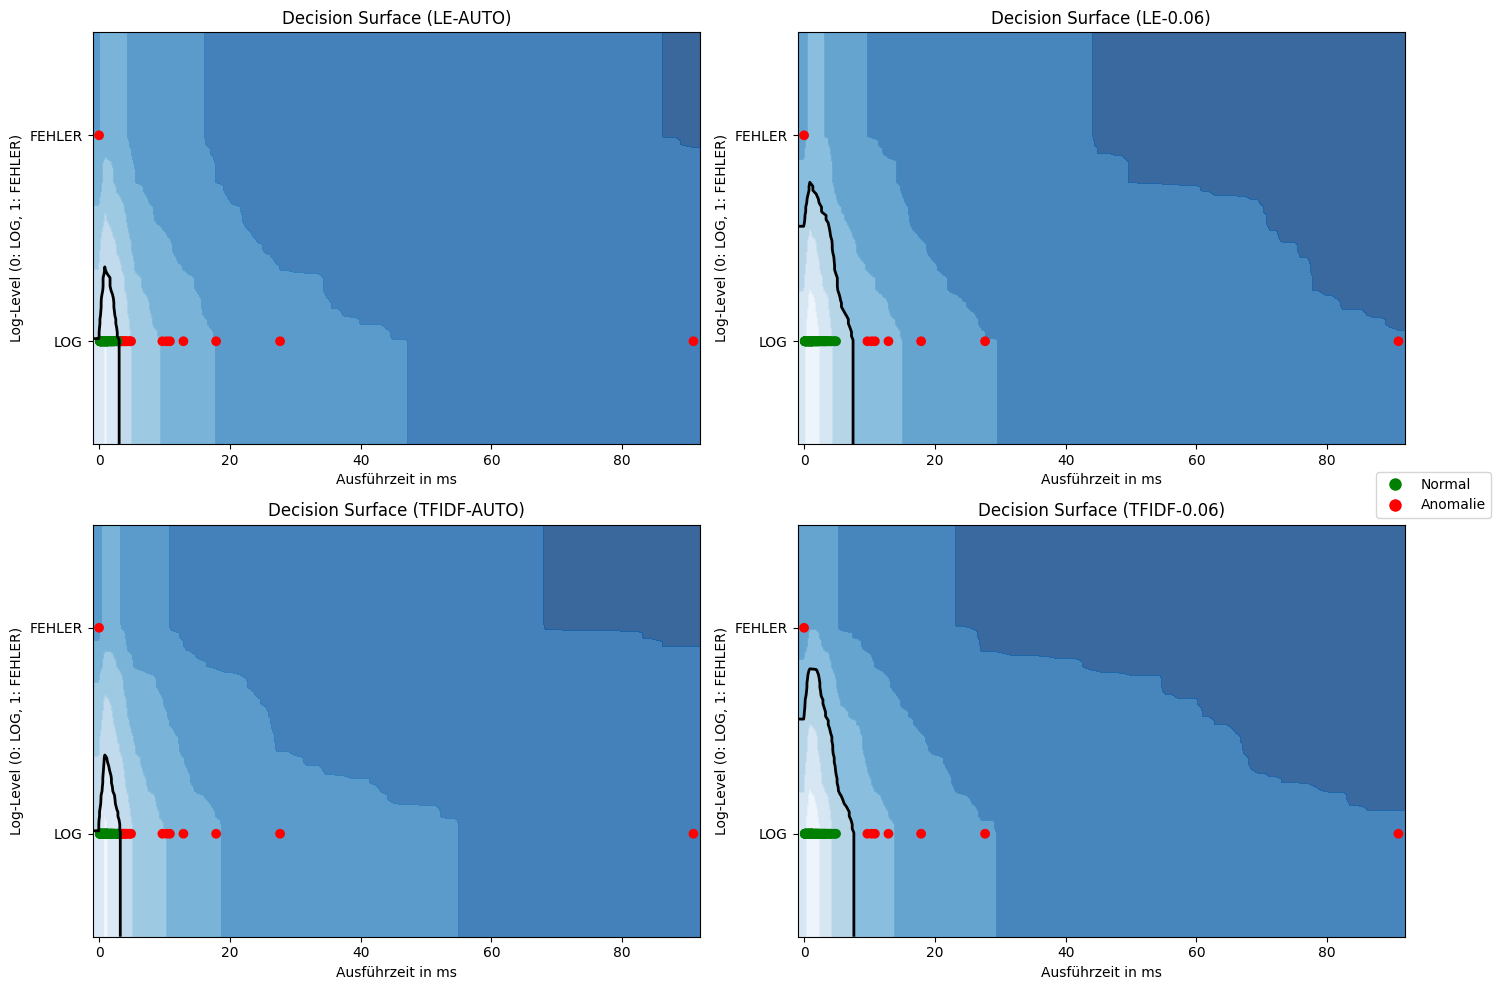

In [ ]:
df_le_plot = df_le.copy()
df_le_plot['level_numeric'] = df_le_plot['level'].apply(lambda x: 1 if x == 'FEHLER' else 0)

df_tfidf_plot = df_tfidf.copy()
df_tfidf_plot['level_numeric'] = df_tfidf_plot['level'].apply(lambda x: 1 if x == 'FEHLER' else 0)


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

plot_data = {
    "LE-AUTO": (model_auto_le, df_le_plot, 'anomaly_auto'),
    "LE-0.06": (model_06_le, df_le_plot, 'anomaly_06'),
    "TFIDF-AUTO": (model_auto_tfidf, df_tfidf_plot, 'anomaly_auto'),
    "TFIDF-0.06": (model_06_tfidf, df_tfidf_plot, 'anomaly_06'),
}

titles = {
    "LE-AUTO": "Decision Surface (LE-AUTO)",
    "LE-0.06": "Decision Surface (LE-0.06)",
    "TFIDF-AUTO": "Decision Surface (TFIDF-AUTO)",
    "TFIDF-0.06": "Decision Surface (TFIDF-0.06)",
}

colors = {-1: 'red', 1: 'green'}

x_min, x_max = df['duration'].min() - 1, df['duration'].max() + 1
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

log_tfidf_vector = tfidf.transform(['LOG']).toarray()[0]
fehler_tfidf_vector = tfidf.transform(['FEHLER']).toarray()[0]


for i, (title_key, (model, dataframe, anomaly_col)) in enumerate(plot_data.items()):
    if "LE" in title_key:
        meshgrid_input = np.column_stack([xx.ravel(), yy.ravel()])
        Z = model.decision_function(meshgrid_input)
    else: # TFIDF
        meshgrid_features_tfidf = np.zeros((len(xx.ravel()), 3))
        for j in range(len(xx.ravel())):
            interpolated_tfidf = (1 - yy.ravel()[j]) * log_tfidf_vector + yy.ravel()[j] * fehler_tfidf_vector
            meshgrid_features_tfidf[j, :2] = interpolated_tfidf
            meshgrid_features_tfidf[j, 2] = xx.ravel()[j]

        Z = model.decision_function(meshgrid_features_tfidf)

    Z = Z.reshape(xx.shape)

    axes[i].contourf(xx, yy, Z, cmap=plt.cm.Blues_r, alpha=0.8)

    axes[i].contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

    scatter = axes[i].scatter(dataframe["duration"], dataframe["level_numeric"], c=dataframe[anomaly_col].map(colors))
    axes[i].set_title(titles[title_key])
    axes[i].set_xlabel("Ausführzeit in ms")
    axes[i].set_ylabel("Log-Level (0: LOG, 1: FEHLER)")
    axes[i].set_yticks([0, 1])
    axes[i].set_yticklabels(['LOG', 'FEHLER'])
    axes[i].set_ylim(y_min, y_max)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Normal', markersize=10, markerfacecolor='green'),
    Line2D([0], [0], marker='o', color='w', label='Anomalie', markersize=10, markerfacecolor='red')
]

fig.legend(handles=legend_elements, loc='center right')

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

Dabei ist zu erkennen, dass der automatische Isolation Forest einen engeren Bereich errechnet hat und somit mehr Einträge als Anomalie ansieht.

Im Nachfolgenden kann ein exemplarischer Baum zur Interpretation dienen. Dabei werden schnelle Isolierungen der Anomalien ersichtlich.

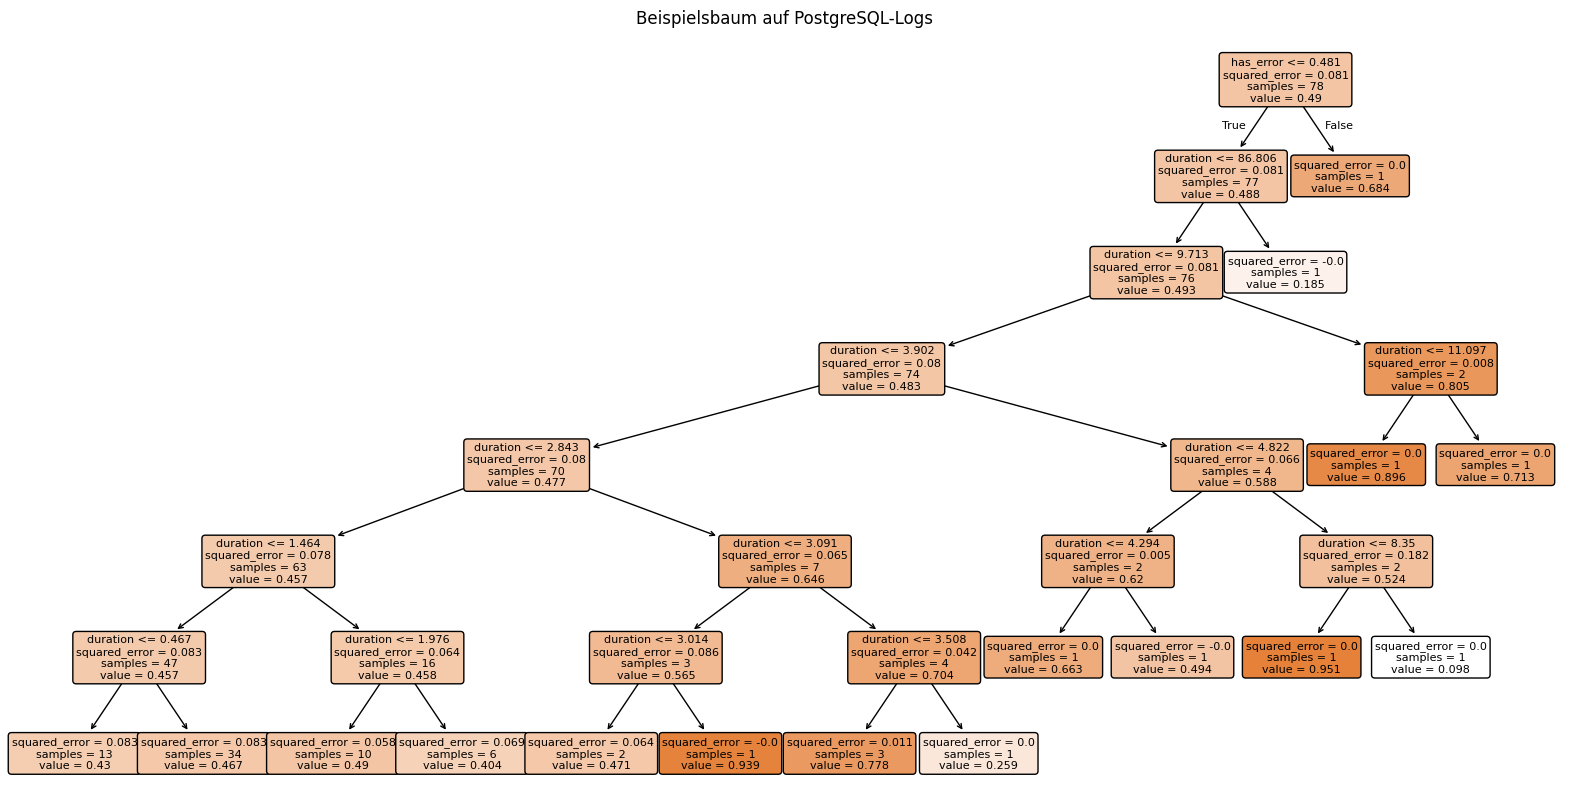

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

exemplary_tree = model_06_le.estimators_[0]

feature_names_le = ['duration', 'has_error']

plt.figure(figsize=(20, 10))
plot_tree(exemplary_tree,
          feature_names=feature_names_le,
          filled=True,
          rounded=True,
          fontsize=8)
plt.title("Beispielsbaum auf PostgreSQL-Logs")
plt.show()